In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import logging
import pandas as pd
import gensim
from gensim.models import KeyedVectors

logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')

In [2]:
# 预训练的词向量文件路径
vec_path = "word2vec.txt"  # 替换为实际路径
# 加载词向量文件
word_vectors = gensim.models.KeyedVectors.load_word2vec_format(vec_path, binary=False)

2025-01-22 23:32:59,983 INFO: loading projection weights from word2vec.txt
2025-01-22 23:33:00,385 INFO: KeyedVectors lifecycle event {'msg': 'loaded (5971, 200) matrix of type float32 from word2vec.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2025-01-22T23:33:00.385240', 'gensim': '4.3.3', 'python': '3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


In [3]:
# 获取原始词向量的维度
embedding_dim = word_vectors.vector_size

# 初始化词汇表，包含特殊标记
vocab = {'<unk>': 0, '[PAD]': 1}  # <unk> 和 [PAD] 的索引分别为 0 和 1

# 将原始词向量添加到词汇表中
for idx, word in enumerate(word_vectors.index_to_key, start=len(vocab)):
    vocab[word] = idx

# 更新 word_vectors，确保包含特殊标记
special_tokens = {'<unk>': np.random.uniform(-0.25, 0.25, embedding_dim),
                  '[PAD]': np.zeros(embedding_dim)}

for token, vector in special_tokens.items():
    if token not in word_vectors:
        word_vectors.add_vector(token, vector)

print("Vocabulary size:", len(vocab))

Vocabulary size: 5973


E:\miniconda3\Lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [4]:
#数据集处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, word_vectors, max_len, unk_token='<unk>'):
        """
        文本数据集类
        :param texts: 文本数据列表，每个元素是一个词索引列表。
        :param labels: 标签列表，与 texts 中的文本一一对应。
        :param word_vectors: 词向量对象，包含词汇表和对应的词向量。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        :param unk_token: 未知词标记，默认为 '<unk>'.
        """
        self.labels = labels
        self.word_vectors = word_vectors
        self.unk_token = unk_token
        self.max_len = max_len

        # 确保 <unk> 和 [PAD] 已经存在于 word_vectors 中
        assert '<unk>' in self.word_vectors.key_to_index, "Vocabulary does not contain '<unk>' token."
        assert '[PAD]' in self.word_vectors.key_to_index, "Vocabulary does not contain '[PAD]' token."

        # 填充或截断文本
        self.text = [self.pad_text(text, max_len) for text in texts]

    def pad_text(self, text, max_len):
        """
        填充或截断文本以匹配指定的最大长度
        :param text: 文本数据列表，每个元素是一个词索引列表。
        :param max_len: 每个文本的最大长度，用于填充或截断文本。
        """
        if not isinstance(text, list):
            raise ValueError("Expected a list of integers as input.")

        padded = text[:max_len]  # 截取前 max_len 个元素
        padding_needed = max_len - len(padded)
        if padding_needed > 0:
            padded.extend([self.word_vectors.key_to_index.get('[PAD]', 0)] * padding_needed)  # 使用[PAD]索引填充
        return padded

    def __len__(self):
        """返回数据集中样本的数量"""
        return len(self.labels)

    def __getitem__(self, index):
        """
        获取指定索引的数据
        :param index: 数据索引。
        :return: 一个元组，包含文本数据和对应的标签。
        """
        text_tensor = torch.tensor(self.text[index], dtype=torch.long)  # 只传递词索引
        label_tensor = torch.tensor(self.labels[index], dtype=torch.long)
        return text_tensor, label_tensor

In [6]:
class TextCNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,num_filters,filter_sizes,num_classes,dropout):
        """
        文本分类模型
        :param vocab_size: 词汇表大小。
        :param embedding_dim: 嵌入维度。
        :param num_filters: 卷积核数量。
        :param filter_sizes: 卷积核大小列表。
        :param num_classes: 分类类别数量。
        :param dropout: 丢弃率。
        """
        super(TextCNN,self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim) # 词嵌入层 #词嵌入层
        self.convs = nn.ModuleList([nn.Conv2d(1,num_filters,(fs,embedding_dim)) for fs in filter_sizes]) #卷积层
        self.dropout = nn.Dropout(dropout) #丢弃层
        self.fc = nn.Linear(len(filter_sizes)*num_filters,num_classes) #全连接层

    def forward(self,x):
        """
        前向传播
        :param x: 输入数据，形状为 (batch_size, seq_len)。
        :return: 输出数据，形状为 (batch_size, num_classes)。
        """
        x = self.embedding(x).unsqueeze(1) #形状为 (batch_size, 1, seq_len, embedding_dim)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs] #relu激活函数，形状为 (batch_size, num_filters, seq_len - filter_size + 1)
        x = [F.max_pool1d(i,i.size(2)).squeeze(2) for i in x] #最大池化，形状为 (batch_size, num_filters)
        x = torch.cat(x, 1) #形状为 (batch_size, num_filters * len(filter_sizes))
        x=self.dropout(x) #丢弃层
        logits = self.fc(x) #全连接层
        return logits

In [6]:
def train_model(model,dataloader,criterion,optimizer,num_epochs=25):
    """
    训练模型
    :param model: 模型。
    :param dataloader: 数据加载器。
    :param criterion: 损失函数。
    :param optimizer: 优化器。
    :param num_epochs: 训练轮数。
    :return: 训练损失列表和准确率列表。
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        logging.info('Epoch {}/{}'.format(epoch+1, num_epochs))
        logging.info('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
            else:
                model.eval()   # 评估模式

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() #梯度清零

                with torch.set_grad_enabled(phase == 'train'): #是否计算梯度
                    outputs = model(inputs) #前向传播
                    _, preds = torch.max(outputs, 1) #预测结果
                    loss = criterion(outputs, labels) #损失函数

                    if phase == 'train':
                        loss.backward() #反向传播
                        optimizer.step() #更新参数

                running_loss += loss.item() * inputs.size(0) #损失累加 # 使用 inputs.size(0) 获取批次大小
                running_corrects += torch.sum(preds == labels.data) #正确预测数量累加

            epoch_loss = running_loss / len(dataloader[phase].dataset) #平均损失
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset) #准确率
            logging.info('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            history[f'{phase}_loss'].append(epoch_loss) #记录损失
    return model, history #返回模型和训练历史

def plot_train_history(history):
    """
    绘制训练和验证损失随时间的变化图
    """
    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(epochs, history['train_loss'],label='train_loss')
    plt.plot(epochs, history['val_loss'], label='val_loss')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
#载入数据
data_file = './data/train_set.csv'
data = pd.read_csv(data_file,sep='\t')
labels = data['label'].values
texts = data['text'].values
#把字符串转换为整数列表
# texts_as_int_lists = [list(map(int, text.split())) for text in texts]

In [10]:
def text_to_int(text, vocab, max_len):
    int_list = [vocab.get(word, vocab['<unk>']) for word in text.split()]
    padded = int_list[:max_len]
    padding_needed = max_len - len(padded)
    if padding_needed > 0:
        padded.extend([vocab['[PAD]']] * padding_needed)
    return padded

texts_as_int_lists = [text_to_int(text, vocab, max_len=900) for text in texts]

In [9]:
#分割数据集为训练集和验证集
X_train,X_test,y_train,y_test = train_test_split(texts_as_int_lists,labels,test_size=0.2,random_state=42)

#创建数据集对象
train_dataset = TextDataset(X_train,y_train,word_vectors,max_len=900)
test_dataset = TextDataset(X_test,y_test,word_vectors,max_len=900)

#创建数据加载器
dataloaders = {
    'train': DataLoader(train_dataset,batch_size=64,shuffle=True),
    'val': DataLoader(test_dataset,batch_size=64,shuffle=False)
}

In [10]:
#初始化模型、损失函数和优化器
model = TextCNN(vocab_size=len(vocab),
                embedding_dim=embedding_dim,
                num_filters=128,
                filter_sizes=[3,4,5],
                num_classes=14,
                dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [11]:
#开始训练模型
trained_model, history = train_model(model,dataloaders,criterion,optimizer,num_epochs=20)

2025-01-22 22:42:15,038 INFO: Epoch 1/20
2025-01-22 22:42:15,038 INFO: ----------
2025-01-22 22:43:45,608 INFO: train Loss: 0.4205 Acc: 0.8753
2025-01-22 22:44:04,055 INFO: val Loss: 0.2426 Acc: 0.9276
2025-01-22 22:44:04,056 INFO: Epoch 2/20
2025-01-22 22:44:04,056 INFO: ----------
2025-01-22 22:45:34,275 INFO: train Loss: 0.2503 Acc: 0.9249
2025-01-22 22:45:52,769 INFO: val Loss: 0.2137 Acc: 0.9363
2025-01-22 22:45:52,770 INFO: Epoch 3/20
2025-01-22 22:45:52,770 INFO: ----------
2025-01-22 22:47:22,950 INFO: train Loss: 0.1828 Acc: 0.9441
2025-01-22 22:47:41,474 INFO: val Loss: 0.2215 Acc: 0.9319
2025-01-22 22:47:41,474 INFO: Epoch 4/20
2025-01-22 22:47:41,475 INFO: ----------
2025-01-22 22:49:11,615 INFO: train Loss: 0.1463 Acc: 0.9549
2025-01-22 22:49:30,099 INFO: val Loss: 0.2225 Acc: 0.9386
2025-01-22 22:49:30,099 INFO: Epoch 5/20
2025-01-22 22:49:30,100 INFO: ----------
2025-01-22 22:51:00,267 INFO: train Loss: 0.1173 Acc: 0.9635
2025-01-22 22:51:18,760 INFO: val Loss: 0.2424 Ac

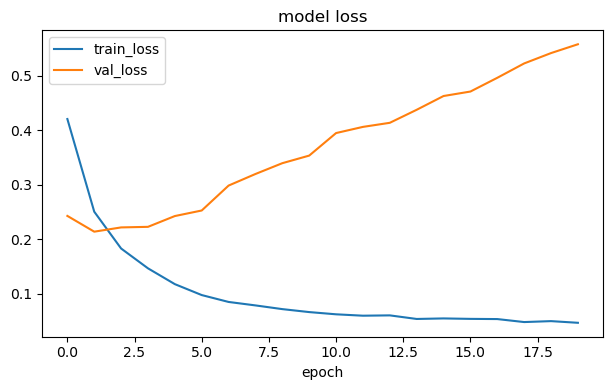

In [12]:
#可视化训练历史情况
plot_train_history(history)

In [20]:
#保存模型
# 保存模型参数到文件
torch.save(trained_model.state_dict(), 'word2vec_textCNN.pth')

model.load_state_dict(torch.load('word2vec_textCNN.pth'))
model.eval()  # 切换到评估模式

C:\Users\kodi\AppData\Local\Temp\ipykernel_15160\3128001896.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('word2vec_textCNN.pth'))


TextCNN(
  (embedding): Embedding(5973, 200)
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 200), stride=(1, 1))
    (1): Conv2d(1, 128, kernel_size=(4, 200), stride=(1, 1))
    (2): Conv2d(1, 128, kernel_size=(5, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=384, out_features=14, bias=True)
)

In [8]:
# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 方法一：加载整个模型对象
# model = torch.load('path_to_saved_model.pth', map_location=device)

# 方法二：加载模型的状态字典
# 首先创建一个与原模型架构相同的实例
model = TextCNN(vocab_size=len(vocab),
                embedding_dim=embedding_dim,
                num_filters=128,
                filter_sizes=[3,4,5],
                num_classes=14,
                dropout=0.2)

# 然后加载状态字典
model.load_state_dict(torch.load('word2vec_textCNN.pth', map_location=device))
model.to(device)  # 将模型移动到相应的设备上
model.eval()  # 切换到评估模式

C:\Users\kodi\AppData\Local\Temp\ipykernel_4984\836746652.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('word2vec_textCNN.pth', map_l

TextCNN(
  (embedding): Embedding(5973, 200)
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 200), stride=(1, 1))
    (1): Conv2d(1, 128, kernel_size=(4, 200), stride=(1, 1))
    (2): Conv2d(1, 128, kernel_size=(5, 200), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=384, out_features=14, bias=True)
)

In [11]:
#构造测试数据集
test_data_file = './data/test_a.csv'
test_data = pd.read_csv(test_data_file,sep='\t')
test_texts = test_data['text'].values
test_texts_as_int_lists = [text_to_int(text, vocab, max_len=900) for text in test_texts]
test_dataset = TextDataset(test_texts_as_int_lists, [0] * len(test_texts_as_int_lists), word_vectors, max_len=900)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
#预测新数据
def predict(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # 将模型移动到相应的设备
    model.eval()      # 切换到评估模式
    predictions = []
    with torch.no_grad():
        for inputs, _ in dataloader:  # 假设新数据没有标签
            inputs = inputs.to(device) # 将数据移动到相应的设备
            outputs = model(inputs)
            # 对于分类任务，通常会使用softmax函数将输出转换为概率分布，然后选择具有最高概率的类别作为预测结果。直接使用torch.max函数获取每行的最大值及其索引。只关心类别索引（预测标签），所以第二个返回值preds就是需要的结果
            _, preds = torch.max(outputs, 1)
            # # 将预测结果从PyTorch张量转换为NumPy数组，并添加到predictions列表中。.cpu()方法确保即使原始张量位于GPU上，也可以安全地转换为NumPy格式。
            predictions.extend(preds.cpu().numpy())

    return predictions

In [17]:
predictions = predict(model, test_dataloader)

In [20]:
pd.DataFrame(predictions,columns=['label']).to_csv('word2vec_textCNN_submit.csv',index=False)